# Building a fine-tuned translation system for English-Malayalam

- toc: true
- branch: master
- badges: true
- hide_binder_badge: true
- comments: true
- author: Kurian Benoy
- categories: [fastai, huggingface, translation, fine tuning, malayalam]
- search_exclude: false
- hide: false

Hey, everyone. We all are familiar with translation systems like using google translate. So today, let's build a fine tuned translation system for converting text from english to malayalam. It's built using Blurr library - built on top of Hugging face and fast.ai made by [Wayde Gilliam](https://twitter.com/waydegilliam). Also our translation system is going to be fine tuned on [top of KDE specific dataset](https://huggingface.co/datasets/kde4). You can find the trained model [here](https://huggingface.co/kurianbenoy/kde_en_ml_translation_model).


![Google Translate](https://upload.wikimedia.org/wikipedia/commons/thumb/2/2b/Screenshot_of_Google_Translate.png/1200px-Screenshot_of_Google_Translate.png)

**Installation**

In [1]:
#collapse
#hide-output
! python3 -m pip install -Uqq datasets fastai
! python3 -m pip install -Uqq transformers[sentencepiece]
! python3 -m pip install -Uqq ohmeow-blurr
! python3 -m pip install -Uqq nltk
! python3 -m pip install -Uqq sacrebleu
! python3 -m pip install -Uqq  git+https://github.com/huggingface/huggingface_hub#egg=huggingface-hub["fastai"]

---
## Loading Data

A translation system is an example of [sequence to sequence models](https://huggingface.co/course/chapter1/7?fw=pt), which is usually used for tasks which involves generating new data. Translation usually needs datasets in both the source language and target language (the language to which it needs to be translated).

We are using [KDE4 datasets](https://huggingface.co/datasets/kde4), and choose both source language and translation language as english and malayalam respectively. Usually these datasets are curated by community volunteers to their native language, and this was probably done by KDE community volunteers in Kerala. When someone is localizing these texts into there in local languague, usually computer science specific terms are still written in english.

In [2]:
import pandas 
from datasets import load_dataset

In [3]:
raw_datasets = load_dataset("kde4", lang1="en", lang2="ml", split="train[:1000]")

Using custom data configuration en-ml-lang1=en,lang2=ml
Reusing dataset kde4 (/home/.cache/huggingface/datasets/kde4/en-ml-lang1=en,lang2=ml/0.0.0/243129fb2398d5b0b4f7f6831ab27ad84774b7ce374cf10f60f6e1ff331648ac)


Most of translation dataset is in form of id and translation json output - with both `en` and `ml` as objects.

In [4]:
raw_datasets[0]

{'id': '0',
 'translation': {'en': 'Add Feed to Akregator',
  'ml': 'അക്രിഗേറ്ററില്\u200d ഫീഡ് കൂട്ടിച്ചേര്\u200dക്കുക'}}

---
## Transforming data into DataLoaders

### Importing libraries and get hugging-face objects

In [18]:
from blurr.text.data.all import *
from blurr.text.modeling.all import *
from blurr.text.utils import *

from fastai.data.all import *
from fastai.callback.all import *
from fastai.learner import load_learner
from fastai.optimizer import *
from transformers import *

In [12]:
#hide-output
pretrained_model_name = "Helsinki-NLP/opus-mt-en-ml"
model_cls = AutoModelForSeq2SeqLM
hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(pretrained_model_name, model_cls=model_cls)

hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

loading configuration file https://huggingface.co/Helsinki-NLP/opus-mt-en-ml/resolve/main/config.json from cache at /home/.cache/huggingface/transformers/ae9605b10d5542ca400f6f0891bb2ee75d9734555fcbbf74ad987eb03c41e049.e9f57d60c3a147cc9716cf6c6cdf1e03ff2738471f36ac092b54dc7816cce404
Model config MarianConfig {
  "_name_or_path": "Helsinki-NLP/opus-mt-en-ml",
  "activation_dropout": 0.0,
  "activation_function": "swish",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "MarianMTModel"
  ],
  "attention_dropout": 0.0,
  "bad_words_ids": [
    [
      24660
    ]
  ],
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 512,
  "decoder_attention_heads": 8,
  "decoder_ffn_dim": 2048,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 24660,
  "decoder_vocab_size": 24661,
  "dropout": 0.1,
  "encoder_attention_heads": 8,
  "encoder_ffn_dim": 2048,
  "encoder_layerdrop": 0.0,
  "encoder_layer

('marian',
 transformers.models.marian.configuration_marian.MarianConfig,
 transformers.models.marian.tokenization_marian.MarianTokenizer,
 transformers.models.marian.modeling_marian.MarianMTModel)

In [13]:
translation_df = pd.DataFrame(raw_datasets["translation"], columns=["en", "ml"])
translation_df.head()

,en,ml
0,Add Feed to Akregator,അക്രിഗേറ്ററില്‍ ഫീഡ് കൂട്ടിച്ചേര്‍ക്കുക
1,Add Feeds to Akregator,അക്രിഗേറ്ററില്‍ ഫീഡുകള്‍ കൂട്ടിച്ചേര്‍ക്കുക
2,Add All Found Feeds to Akregator,എല്ലാ ഫീഡുകളും അക്രിഗേറ്ററില്‍ കൂട്ടിച്ചേര്‍ക്കുക
3,Subscribe to site updates (using news feed),സൈറ്റുകളിലെ പുതുമകളറിയാന്‍ വരിക്കാരനാകുക (വാര്‍ത്താ ഫീഡുകള്‍ ഉപയോഗിച്ചു്)
4,Imported Feeds,എടുത്ത ഫീഡുകള്‍


In [14]:
blocks = (Seq2SeqTextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), noop)
dblock = DataBlock(blocks=blocks, get_x=ColReader("en"), get_y=ColReader("ml"), splitter=RandomSplitter())

In [15]:
dls = dblock.dataloaders(translation_df, bs=16)
dls.show_batch(dataloaders=dls, max_n=2, input_trunc_at=100, target_trunc_at=250)

,text,target
0,A▁version▁control▁history▁entry▁consists of▁several▁lines.▁Specify the▁regular▁expression▁to▁detect,ഒരു ഭാഷാന്തര നിയന്ത്രണത്തിന്റെ നാള്വഴി ചേര്ക്കുന്നതില് പല വരികളുണ്ടാകും. ആദ്യത്തെ വരി കണ്ടുപിടിക്കാനുള്ള നിത്യഭാവം നിര്ദ്ദേശിക്കുക (മുന്നിലെ വിശദീകരണം കൂടാതെ). ഇനം തിരിക്കാനുപയോഗിക്കുന്ന കീകളെ ഒന്നിച്ചാക്കാന് ബ്രാക്കറ്റുകള് ഉപയോഗിക്കുക. ഒഴിച്ചു വിട്ട
1,▁Mailody▁can▁store▁all▁attchements of▁all▁messages in▁a▁certain▁folder.▁Then▁you▁never▁have▁to▁save▁,"എല്ലാ സന്ദേശങ്ങളുടേയും എല്ലാ അനുബന്ധങ്ങളും ഒരു പ്രത്യേക അറയില് സൂക്ഷിക്കാന് മെയിലഡിക്ക് കഴിയും. നിങ്ങള്ക്കവയെ സന്ദേശങ്ങളില്നിന്ന് പ്രത്യേകം സൂക്ഷിക്കേണ്ടതില്ല. അവ അറയില് ഉണ്ടായിരിക്കും. പ്രത്യേകം ശ്രദ്ധിക്കുക, ഈ അറ ഇടക്കിടക്ക് കാലിയാക്കിക്കൊണ്ടിരിക്ക"


---
## Training fine-tuned translation system

### Using blurr High-level API

(At the moment looks broken)

In [20]:
from blurr.text.utils import BlurrText

NLP = BlurrText()

In [21]:
#hide-output
learn = BlearnerForTranslation.from_data(
    translation_df,
    pretrained_model_name,
    src_lang_name="English",
    src_lang_attr="en",
    trg_lang_name="Malayalam",
    trg_lang_attr="ml",
    dl_kwargs={"bs": 16},
)

loading configuration file https://huggingface.co/Helsinki-NLP/opus-mt-en-ml/resolve/main/config.json from cache at /home/.cache/huggingface/transformers/ae9605b10d5542ca400f6f0891bb2ee75d9734555fcbbf74ad987eb03c41e049.e9f57d60c3a147cc9716cf6c6cdf1e03ff2738471f36ac092b54dc7816cce404
Model config MarianConfig {
  "_name_or_path": "Helsinki-NLP/opus-mt-en-ml",
  "activation_dropout": 0.0,
  "activation_function": "swish",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "MarianMTModel"
  ],
  "attention_dropout": 0.0,
  "bad_words_ids": [
    [
      24660
    ]
  ],
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 512,
  "decoder_attention_heads": 8,
  "decoder_ffn_dim": 2048,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 24660,
  "decoder_vocab_size": 24661,
  "dropout": 0.1,
  "encoder_attention_heads": 8,
  "encoder_ffn_dim": 2048,
  "encoder_layerdrop": 0.0,
  "encoder_layer

NameError: name 'NLP' is not defined

In [12]:
metrics_cb = BlearnerForTranslation.get_metrics_cb()
learn.fit_one_cycle(1, lr_max=4e-5, cbs=[metrics_cb])

Downloading:   0%|          | 0.00/2.48k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.55k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


Downloading:   0%|          | 0.00/2.36k [00:00<?, ?B/s]

epoch,train_loss,valid_loss,bleu,meteor,sacrebleu,time
0,4.847442,3.989661,0.028411,0.188749,5.151875,00:51


In [13]:
learn.show_results(learner=learn, input_trunc_at=500, target_trunc_at=250)

,text,target,prediction
0,"A▁version▁control▁history▁entry▁consists of▁several▁lines.▁Specify the▁regular▁expression▁to▁detect the▁first▁line (without the▁leading▁comment).▁Use▁parentheses▁to▁group the▁keys▁you▁want▁to▁use▁for▁sorting.▁If▁left▁empty,▁then▁KDiff3▁assumes▁that▁empty▁lines▁separate▁history▁entries.▁See the▁documentation▁for▁details.",ഒരു ഭാഷാന്തര നിയന്ത്രണത്തിന്റെ നാള്വഴി ചേര്ക്കുന്നതില് പല വരികളുണ്ടാകും. ആദ്യത്തെ വരി കണ്ടുപിടിക്കാനുള്ള നിത്യഭാവം നിര്ദ്ദേശിക്കുക (മുന്നിലെ വിശദീകരണം കൂടാതെ). ഇനം തിരിക്കാനുപയോഗിക്കുന്ന കീകളെ ഒന്നിച്ചാക്കാന് ബ്രാക്കറ്റുകള് ഉപയോഗിക്കുക. ഒഴിച്ചു വിട്ട,"[ഒരു പതിപ്പ് നിയന്ത്രകന്റെ നിയന്ത്രണം പല വരികളിലുമുണ്ടു്. ആദ്യത്തെ വരി (വലുപ്പത്തില്നിയ്ക്കു്) കണ്ടെത്താനുള്ള ക്രമമായ പ്രയോഗം വ്യക്തമാക്കുക. നിങ്ങൾ ടൈപ്പ് ചെയ്യുവാനുള്ള കീകൾ ടൈപ്പ് ചെയ്യുക. വിട്ടുപോയാൽ, ഒഴിഞ്ഞ വര്ണ്ണങ്ങള്ക്കുള്ള വര്ണ്ണങ്ങള്ക്കുള്ള വര്ണങ്ങള്ണങ്ങള്ക്ക്ണങ്ങള്ണങ്ങള്ക്കങ്ങള്ണ്ക്കങ്ങള്ക്കണ്ടു്. വിവരങ്ങള്ക്ക് KDef3, ഡാറ്റ നഷ്ടപ്പെടാനോ മറ്റു് കേടുപാടുകള്ക്കോ തടയാനോ നിങ്ങൾക്ക് സിസ്റ്റം സസ്പെൻഡ് ചെയ്യാനോ, ഹ്യൂസ്ബര്ഡ് ചെയ്യാനോ സാധിക്കുന്നു, അതിനാൽ ബാറ്ററി അധികാരത്തിൽ നിന്ന് നിങ്ങൾ ഓടരുത്. മെഷീൻ ക്രമീകരിക്കുന്ന പ്രവർത്തനങ്ങളുടെ എണ്ണം താഴെ ക്രമീകരിക്കുക., ഒരു ഇമെയിൽ വിലാസം പോലെ കാണുന്ന ഒരു കണ്ണിയിൽ ക്ലിക്ക് ചെയ്തിട്ടുണ്ടു്. പക്ഷേ അതിന്റെ പിൻഭാഗത്ത് ഇതു് ചേരുന്നില്ല:% 1 lock to be track about to cause for play for play played by completion% 2, നിങ്ങൾ ശരിക്കും എങ്ങോട്ടു് പോകുമെന്നു് കൃത്യമായി സൂചിപ്പിക്കുവാൻ സാധ്യമല്ലാത്ത ഒരു കണ്ണിയിൽ ക്ലിക്ക് ചെയ്തിട്ടുണ്ടു്. ഈ സർവറിലുള്ള ഒരു താള് ശരിക്കും കാണണമെങ്കിൽ ദയവായി പരിശോധിക്കുക:% 1 അവിടെ പോകണമോ? @ title: group column]"


### Using mid-level of blurr APIs

In [22]:
b = dls.one_batch()

In [23]:
len(b), b[0]["input_ids"].shape, b[1].shape

(2, torch.Size([16, 72]), torch.Size([16, 114]))

In [24]:
dls.show_batch(dataloaders=dls, input_trunc_at=250, target_trunc_at=250)

,text,target
0,"A▁version▁control▁history▁entry▁consists of▁several▁lines.▁Specify the▁regular▁expression▁to▁detect the▁first▁line (without the▁leading▁comment).▁Use▁parentheses▁to▁group the▁keys▁you▁want▁to▁use▁for▁sorting.▁If▁left▁empty,▁then▁KDiff3▁assumes▁that▁e",ഒരു ഭാഷാന്തര നിയന്ത്രണത്തിന്റെ നാള്വഴി ചേര്ക്കുന്നതില് പല വരികളുണ്ടാകും. ആദ്യത്തെ വരി കണ്ടുപിടിക്കാനുള്ള നിത്യഭാവം നിര്ദ്ദേശിക്കുക (മുന്നിലെ വിശദീകരണം കൂടാതെ). ഇനം തിരിക്കാനുപയോഗിക്കുന്ന കീകളെ ഒന്നിച്ചാക്കാന് ബ്രാക്കറ്റുകള് ഉപയോഗിക്കുക. ഒഴിച്ചു വിട്ട
1,"▁Mailody▁can▁store▁all▁attchements of▁all▁messages in▁a▁certain▁folder.▁Then▁you▁never▁have▁to▁save▁it▁from the▁messages,▁it▁is▁simply in▁that▁folder.▁Please▁note▁that▁you▁need▁to▁clear▁that▁folder▁now▁and▁then,▁else▁your▁system▁may▁run▁out of▁space▁","എല്ലാ സന്ദേശങ്ങളുടേയും എല്ലാ അനുബന്ധങ്ങളും ഒരു പ്രത്യേക അറയില് സൂക്ഷിക്കാന് മെയിലഡിക്ക് കഴിയും. നിങ്ങള്ക്കവയെ സന്ദേശങ്ങളില്നിന്ന് പ്രത്യേകം സൂക്ഷിക്കേണ്ടതില്ല. അവ അറയില് ഉണ്ടായിരിക്കും. പ്രത്യേകം ശ്രദ്ധിക്കുക, ഈ അറ ഇടക്കിടക്ക് കാലിയാക്കിക്കൊണ്ടിരിക്ക"
2,"▁There▁is▁no▁Inbox▁found in▁any▁resource.▁Starting▁a▁new▁message▁will▁cause the▁message▁to▁be▁lost▁after▁you▁have▁sent▁it.▁You▁will▁not▁have▁a▁local▁copy▁anymore.▁If▁you▁want▁a▁copy,▁one▁way▁to▁do▁this▁is▁to▁add▁yourself▁as▁a CC▁to the▁message.<pad><",വിഭവങ്ങളിലൊന്നും ഒരു ഇന്ബോക്സ് കാണുന്നില്ല. ഒരു പുതിയ സന്ദേശം തുടങ്ങുന്നത് അത് അയച്ച ശേഷം നഷ്ടപ്പെടാന് കാരണമാകും. പ്രാദേശിക പകര്പ്പുകളൊന്നും ഒരിക്കലും ലഭ്യമല്ലാതാവും. ഉദാഹരണമായി ഒരു പകര്പ്പ് ആവശ്യമുണ്ടെങ്കില് ഒരു കാര്ബണ് പതിപ്പുകൂടി കൂട്ടിച്ചേര്ത്തതാ
3,"▁To▁prevent▁data▁loss▁or▁other▁damage,▁you▁can▁have the▁system suspend▁or▁hibernate,▁so▁you▁do▁not▁accidentally▁run▁out of▁battery▁power.▁Configure the▁number of▁minutes▁below▁which the▁machine▁will▁run the▁configured▁action.<pad><pad><pad><pad><pad>","വിവരനഷ്ടമോ ഹാനിയോ തടയാന്, സിസ്റ്റം മയങ്ങുകയോ ശിശിരനിദ്രയിലാകുകയോചെയ്യാവുന്നതാണ്, അങ്ങനെ ആകസ്മികമായിട്ടുപോലും ബാറ്ററി ഊര്ജ്ജം തീരാതിരിയ്ക്കും. ക്രമീകരിച്ച നടപടിയുമായി മുന്നോട്ടു് പോകേണ്ടതു് എത്ര മിനിറ്റുകളില് താഴെയാകുമ്പോഴാണെന്നു് താഴെ ക്രമീകരിയ്ക്കുക"
4,▁AutoSync▁is▁a▁feature▁from MP3tunes▁which▁allows▁you▁to▁automatically▁move▁your▁music▁between▁computers▁and▁devices.▁You▁can▁upload▁music▁from▁one▁location▁and▁have▁it▁download▁instantly▁to▁other▁locations.<pad><pad><pad><pad><pad><pad><pad><pad><pa,Enable harmony
5,▁Loading▁external▁images▁gives▁spammers the▁acknowledgement▁that▁you▁received▁this▁message▁so▁they▁will▁use▁your▁email▁address▁to▁spam▁you.▁So▁you▁should▁only▁continue▁for▁very▁trusted▁messages.<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><,പുറമെനിന്നൊരു ചിത്രം കയറ്റുന്നത് നിങ്ങള്ക്ക് ഈ സന്ദേശം ലഭിച്ചെന്ന മടക്കരശീതി ചവറയയ്ക്കുന്നവര്ക്ക് ലഭിച്ചേക്കാം. അവര് നിങ്ങളുട ഇതപാല് വിലാസം നിങ്ങള്ക്കു് നേരേയും ചവറയയ്ക്കാനുപയോഗിച്ചേക്കാം. അതുകൊണ്ട് വളരെ വിശ്വസ്ത സന്ദേശങ്ങള് മാത്രം തുടര്ന്നാല് മതി.
6,"▁Regular▁expression▁for▁lines▁where▁KDiff3▁should▁automatically▁choose▁one▁source.▁When▁a▁line▁with▁a▁conflict▁matches the▁regular▁expression▁then -▁if▁available - C,▁otherwise B▁will▁be▁chosen.<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><","കെഡിഫ്3 സ്വതന്ത്രമായി ഒരു സ്രോതസ്സ് തെരഞ്ഞെടുക്കുന്നിടത്ത് വരികള്ക്കുള്ള നിത്യഭാവം. സംഘട്ടനമുള്ള വരി ചേര്ന്നുവരുമ്പോള് അതിന്റെ നിത്യഭാവം - സി ഉണ്ടെങ്കില് അത്, അല്ലെങ്കില് ബി തെരഞ്ഞെടുക്കപ്പെടും."
7,▁Mailody▁is▁able▁to▁convert▁your▁plain▁message▁to▁a▁html▁message▁and▁include▁that in the▁outgoing▁message.▁This▁means the▁receiver▁will▁also▁have▁clickable▁links▁and▁colored▁quote▁levels.<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pa,നിങ്ങളുടെ സാദാ സന്ദേശം എച്ച്ടിഎംഎല് സന്ദേശമാക്കി മാറ്റി അത് പുറത്തേക്ക് അയക്കുന്ന സന്ദേശത്തില് ഉള്പ്പെടുത്താന് മെയിലഡിക്കു കഴിയും. അതായത് ഞൊട്ടാവുന്ന കണ്ണികളും വര്ണ്ണ ഉദ്ധരണി തലവും സ്വീകര്ത്താവിനുകൂടി ലഭ്യമാവും
8,▁You▁have▁clicked▁on▁a▁link▁which▁might▁not▁indicate▁correctly▁where▁you▁are▁really▁going▁to.▁Please▁check▁if▁you▁really▁want▁to▁view▁a▁page▁on▁this▁server:▁%1▁Do▁you▁want▁to▁go▁there?<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><,നിങ്ങള് ഒരു കണ്ണിയില

In [25]:
seq2seq_metrics = {"bleu": {"returns": "bleu"}, "meteor": {"returns": "meteor"}, "sacrebleu": {"returns": "score"}}

model = BaseModelWrapper(hf_model)
learn_cbs = [BaseModelCallback]
fit_cbs = [Seq2SeqMetricsCallback(custom_metrics=seq2seq_metrics)]

learn = Learner(
    dls,
    model,
    opt_func=partial(Adam),
    loss_func=PreCalculatedCrossEntropyLoss(),  # CrossEntropyLossFlat()
    cbs=learn_cbs,
    splitter=partial(blurr_seq2seq_splitter, arch=hf_arch),
)

learn.freeze()

[nltk_data] Downloading package wordnet to /home/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /home/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


SuggestedLRs(minimum=0.0003019951749593019, steep=7.585775847473997e-07, valley=0.0004786300996784121, slide=3.0199516913853586e-05)

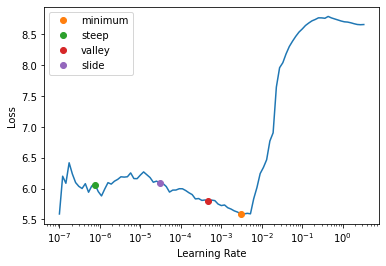

In [26]:
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [34]:
learn.fit_one_cycle(15, lr_max=5e-4, cbs=fit_cbs)

epoch,train_loss,valid_loss,time
0,3.921071,4.076205,00:23
1,3.760781,3.953559,00:23
2,3.699132,4.087067,00:31
3,3.605387,4.011840,00:23
4,3.422987,3.968509,00:27
5,3.247432,4.001950,00:21
6,3.159026,3.826096,00:33
7,3.007944,3.859786,00:28
8,2.888069,3.829450,00:23
9,2.819236,3.796196,00:27


In [35]:
learn.show_results(learner=learn, input_trunc_at=500, target_trunc_at=500)

,text,target,prediction
0,"▁You▁have▁clicked▁on▁a▁link▁which▁looks▁like▁an▁email▁address,▁but the▁link▁behind▁it▁does▁not▁match▁this:▁%1▁Do▁you▁want▁to▁follow the▁original▁link▁or▁simply▁compose▁a▁new▁email▁to▁%2?","നിങ്ങള് ഒരു കണ്ണിയില് ഞൊട്ടിയത് ഒരു ഇതപാല് വിലാസം പോലെയിരിക്കുന്നു. എന്നാല് ഇതിന്റെ പിന്നിലെ കണ്ണിയുമായി ഇതിന് സാദൃശ്യമൊന്നുമില്ല:% 1 ഇതിന് മുമ്പത്തെ അസ്സല് കണ്ണി തന്നെ തുടരാന് നിങ്ങള് ആഗ്രഹിക്കുന്നുണ്ടോ, അതോ വെറുതെ% 2ലേക്ക് ഒരു പുതിയ ഇതപാല് തീര്ത്താല് മതിയോ?","[ഒരു ഇതപാല്꠱ വിലാസമായിത്തന്നെ ഞൊട്ടിയത് നിങ്ങളെവിടേക്കാണ്, ഈ കണ്ണി ചേര്ക്കുന്നു:% 1 അഡാപ്റ്റീകരിയ്ക്കുകയോ പുതിയ ഒരു കണ്ണിയിലേയ്ക്കു് മാറുകയോ ചെയ്യണോ?, First part of: Magnatune. com database update complete. Added 3 tracks on 4 albums from 5 artists., യാന്ത്രികമായ അഡാപ്റ്റിന്റെ ഫലം, നിലവിലുള്ള മത്സരത്തിലേക്ക് ചാടുന്നതിന് മുമ്പായി, തെരഞ്ഞെടുത്തിരിക്കുന്ന സമയത്തിനായി കാണിക്കപ്പെടും. അടുത്ത സംഘട്ടനത്തിലേക്ക് ചാടുന്നതിന് മുമ്പായി, @ title: window, നിങ്ങളുടെ ഇതപാല്꠱ ചേര്꠱ക്കുക മാര് പശ്ചാത്തപിക്കുകട്ടയില്♬നിന്ന് നേരിട്ട് തന്നെ വാങ്ങുന്ന ഏതൊരു വിവരവും കയറ്റുക., പ്രത്യേകതരം മാർഗങ്ങളോടെ കണ്ടെത്താനുള്ള അറയുടെ ഫിൽറ്റർ ചിട്ടപ്പെടുത്തുക. മൂന്നു മിനിറ്റോളം നീണ്ട വഴിയുള്ള പാതയാണ് അത്., Last. fm: errorMessage, നിങ്ങളുടെ ഫയലില്꠱ ഉള്ള പോലെ നാള്꠱വഴി തുടങ്ങുന്ന വരിമുന്നിലെ വ്യാഖ്യാ꠱നത്തോടെ പകര്♬ത്തുക., (""വെളുത്തഅച്ചകലം"" പ്രവര് പശ്ചാത്തപിക്കുകത്തമരഹിതമാക്കിയാല് പശ്ചാത്തപിക്കുക ഒഴിഞ്ഞ ഇടങ്ങളിലെ വ്യ അല്ലാഹുസജ്ജീകരണങ്ങള്꠱ ഒഴിവാക്കുന്നു.), അനുബന്ധങ്ങളുടെ വലിപ്പം% 1% 1% 1% 1 is one, discharge rate in Watts, representing the this track is state, update, this track (""Cancel"" and ""Undo"") with samplaylist label in the layouts, No option was given, this is the error message telling the user he needs at least one, do not translate install, remove, upgrade nor list, ASIII OF TRANSLATORS, ഓണ്♬: വരികളുടെ അന്തര്꠱വ്വഭാവം ഒരു പുതിയ വരിക്ക് ഉപയോഗിക്കുന്നു., ബാറ്ററിയിലെ ഊര് പശ്ചാത്തപിക്കുകജ്ജം തീരാറായി, ഇപ്പോള്꠱ സ്ക്രീന് പശ്ചാത്തപിക്കുക ശൂന്യതെങ്ങനെ?, ഒരു ഫലത്തിൽ എത്ര ഫലം കാണിക്കുമെന്നു വ്യക്തമാക്കുക., ഫയല്꠱ പകര്꠱പ്പെടുക്കുമ്പോള്꠱ പിശക്: എഴുതുന്നത് പരാജയപ്പെട്ടു. ഫയല്꠱ നാമം:% 1, ഏസി അഡാപ്റ്റര്꠱ കുത്തിയിരിയ്ക്കുന്നു, ബാറ്ററി ദശയിലേയ്ക്കു് മാറുന്നു.]"


---
## Now let's translate with our trained models

### blurr top 3 translation predictions

In [36]:
test_text = "How are you doing"


outputs = learn.blurr_generate(test_text, key="translation_texts", num_return_sequences=3)
outputs

[{'translation_texts': ['എന്തൊക്കെയുണ്ട്?',
   'സുഖമാണോ?',
   'എന്തൊക്കെയുണ്ട് വിശേഷം?']}]

### Saving trained ML model

In [37]:
export_fname = "saved_model"


learn.metrics = None
learn.export(fname=f"{export_fname}.pkl")

In [38]:
from huggingface_hub import push_to_hub_fastai

push_to_hub_fastai(
    learn,
    "kurianbenoy/kde_en_ml_translation_model",
    commit_message="New version with 15 epoch of training",
)

Cloning https://huggingface.co/kurianbenoy/kde_en_ml_translation_model into local empty directory.
W0507 13:57:48.364456 140611695040320 repository.py:665] Cloning https://huggingface.co/kurianbenoy/kde_en_ml_translation_model into local empty directory.


Download file translation_export.pkl:   0%|          | 7.59k/221M [00:00<?, ?B/s]

Download file model.pkl:   0%|          | 8.00k/220M [00:00<?, ?B/s]

Download file pytorch_model.bin:   0%|          | 8.00k/217M [00:00<?, ?B/s]

Clean file saved_model.pkl:   1%|1         | 1.00k/96.0k [00:00<?, ?B/s]

Clean file model.pkl:   0%|          | 1.00k/220M [00:00<?, ?B/s]

Clean file translation_export.pkl:   0%|          | 1.00k/221M [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/217M [00:00<?, ?B/s]

Upload file model.pkl:   0%|          | 32.0k/221M [00:00<?, ?B/s]

remote: Enforcing permissions...        
remote: Allowed refs: all        
To https://huggingface.co/kurianbenoy/kde_en_ml_translation_model
   a5e7e23..c9ca014  main -> main

W0507 13:59:34.066033 140611695040320 repository.py:1144] remote: Enforcing permissions...        
remote: Allowed refs: all        
To https://huggingface.co/kurianbenoy/kde_en_ml_translation_model
   a5e7e23..c9ca014  main -> main



'https://huggingface.co/kurianbenoy/kde_en_ml_translation_model/commit/c9ca0142086f8d7f73a9c5fa01abb8c10589868d'

### Prediction with our trained model

#### Correct Prediction

In [39]:
test_text = "How are you doing"

inf_learn = load_learner(fname=f"{export_fname}.pkl")
inf_learn.blurr_translate(test_text)

[{'translation_texts': 'എന്തൊക്കെയുണ്ട്?'}]

In [40]:
test_text1 = "Add All Found Feeds to Akregator."

inf_learn = load_learner(fname=f"{export_fname}.pkl")
inf_learn.blurr_translate(test_text1)

[{'translation_texts': 'എല്ലാ ഫീഡുകളും അക്രിഗേറ്ററില്꠱ കൂട്ടിച്ചേര്꠱ക്കുക.'}]

#### Wrong Prediction

In [41]:
test_text2 = "Subscribe to site updates (using news feed)."

inf_learn = load_learner(fname=f"{export_fname}.pkl")
inf_learn.blurr_translate(test_text2)

[{'translation_texts': 'അടയാളമിടാനുള്ള ഉപാധികൾക്കായി (മുന്നിലെ മെയിലഡികൾ)മുഴുമിച്ചു് is discharge rate rate instally playlist column name and token for playlist layouts'}]

Expected: 'സൈറ്റുകളിലെ പുതുമകളറിയാന്\u200d വരിക്കാരനാകുക (വാര്\u200dത്താ ഫീഡുകള്\u200d ഉപയോഗിച്ചു്

## Thanks to

- Wayde Gilliam - for creating blurr, and helping with doubts in translation bits
- Kevin Bird - for helping in editing the article.

fin.